In [1]:
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel
import torch

# if you have CUDA or MPS, set it to the active device like this
device = "cuda" if torch.cuda.is_available() else \
         ("mps" if torch.backends.mps.is_available() else "cpu")
model_id = "openai/clip-vit-base-patch32"

# we initialize a tokenizer, image processor, and the model itself
tokenizer = CLIPTokenizerFast.from_pretrained(model_id)
processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id).to(device)

In [2]:
prompt = "a bird with ice attribute"

# create transformer-readable tokens
inputs = tokenizer(prompt, return_tensors="pt").to(device)
inputs

{'input_ids': tensor([[49406,   320,  3329,   593,   733,   527,  5493, 49407]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

In [3]:
# use CLIP to encode tokens into a meaningful embedding
text_emb = model.get_text_features(**inputs)
text_emb.shape

torch.Size([1, 512])

In [4]:
text_emb.min(), text_emb.max()

(tensor(-2.0724, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(4.8821, device='cuda:0', grad_fn=<MaxBackward1>))

In [5]:
from PIL import Image

image = processor(
    text=None,
    images=Image.open("saved_images/abomasnow_2058735963577945329.png"),
    return_tensors='pt'
)['pixel_values'].to(device)

In [6]:
image.shape

torch.Size([1, 3, 224, 224])

/tmp/ipykernel_44722/3309829449.py:4: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3675.)
  plt.imshow(image.squeeze(0).T.detach().cpu().numpy())
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.145897].


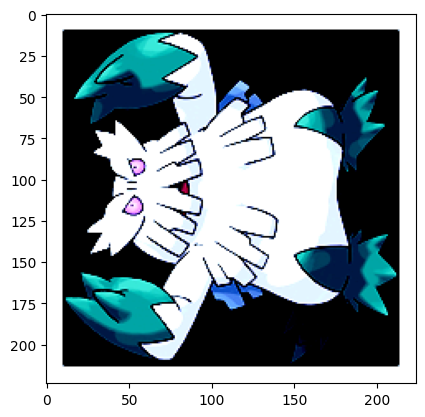

In [7]:
import matplotlib.pyplot as plt
# we can still visualize the processed image

plt.imshow(image.squeeze(0).T.detach().cpu().numpy())

In [8]:

img_emb = model.get_image_features(image)
img_emb.shape

torch.Size([1, 512])

In [9]:
img_emb

tensor([[ 3.9096e-01,  8.1289e-02, -1.3162e-01,  9.2828e-02,  2.6597e-01,
          4.8082e-02,  9.2627e-02,  2.3087e-01,  4.5377e-01, -2.8452e-01,
          5.6122e-01, -1.7808e-01,  1.7953e-01, -4.6964e-01,  1.2608e-01,
          2.6305e-02,  2.2152e-01,  5.0453e-01, -1.9292e-01, -1.2477e-02,
         -6.1350e-01, -3.8132e-01,  1.5375e-01, -2.0861e-01, -1.2663e-01,
          3.4384e-01,  2.3834e-01, -3.0008e-01, -1.9423e-01,  4.2244e-02,
          1.7858e-01,  4.6738e-01,  3.7490e-01, -3.7020e-01,  4.6922e-01,
         -2.9780e-01,  1.8911e-02,  3.2929e-01,  3.9615e-01,  2.2057e-01,
         -5.1451e-01, -3.0438e-01, -9.3648e-02, -1.7054e-01,  4.4864e-01,
          1.5876e+00, -2.9252e-01,  2.7960e-01, -7.5354e-02,  9.6536e-02,
         -9.9773e-02,  9.5280e-03,  4.1374e-01, -1.3719e-01, -2.2109e-01,
          3.6428e-01, -9.7203e-03, -1.9299e-01,  1.1644e-01,  6.3924e-01,
          1.4027e+00, -2.8672e-01, -2.4707e-01,  1.4610e-01,  5.2329e-01,
         -1.3541e-01, -6.0311e-02,  2.

In [27]:
import datasets

dataset = datasets.load_dataset("wanghaofan/pokemon-wiki-captions")

import os
from datasets import Dataset
import PIL.Image as Image

def save_image_and_get_path(example, save_dir):
    # Create a unique filename
    filename = f"{example['name_en']}_{hash(example['text_en'])}.png"
    filepath = os.path.join(save_dir, filename)
    
    # Save the image
    example['image'].save(filepath)
    
    # Add the filepath to the example
    example['image_filepath'] = filepath
    
    return example

def process_dataset(dataset, save_dir):
    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)
    
    # Apply the save_image_and_get_path function to each example
    return dataset.map(lambda example: save_image_and_get_path(example, save_dir))

# Specify the directory where you want to save the images
save_directory = "./saved_images"

# Process the dataset
dataset = process_dataset(dataset, save_directory)

/home/dnth/anaconda3/envs/postgresql-multimodal/lib/python3.10/site-packages/datasets/load.py:2562: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=all_checks' instead.
  warnings.warn(


ExpectedMoreDownloadedFilesError: {'https://huggingface.co/datasets/frgfm/imagenette/resolve/main/metadata/imagenette2/train.txt', 'https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz', 'https://huggingface.co/datasets/frgfm/imagenette/resolve/main/metadata/imagenette2/val.txt'}

In [11]:
dataset['train']

Dataset({
    features: ['image', 'name_en', 'name_zh', 'text_en', 'text_zh', 'image_filepath'],
    num_rows: 898
})

In [12]:
import numpy as np

np.random.seed(0)
# select 100 random image index values
sample_idx = np.random.randint(0, len(dataset)+1, 100).tolist()
# extract the image sample from the dataset
images = [dataset['train'][i]['image'] for i in sample_idx]

# extract all images from the dataset
images = [dataset['train'][i]['image'] for i in range(len(dataset['train']))]

In [13]:
from tqdm.auto import tqdm

batch_size = 16
image_arr = None

for i in tqdm(range(0, len(images), batch_size)):
    # select batch of images
    batch = images[i:i+batch_size]
    # process and resize
    batch = processor(
        text=None,
        images=batch,
        return_tensors='pt',
        padding=True
    )['pixel_values'].to(device)
    # get image embeddings
    batch_emb = model.get_image_features(pixel_values=batch)
    # convert to numpy array
    batch_emb = batch_emb.squeeze(0)
    batch_emb = batch_emb.cpu().detach().numpy()
    # add to larger array of all image embeddings
    if image_arr is None:
        image_arr = batch_emb
    else:
        image_arr = np.concatenate((image_arr, batch_emb), axis=0)

  0%|          | 0/57 [00:00<?, ?it/s]

In [14]:
image_arr.shape


(898, 512)

In [15]:
image_arr.min(), image_arr.max()


(-8.882089, 2.9840744)

In [16]:
np.linalg.norm(image_arr, axis=1).shape


(898,)

In [17]:

image_arr = image_arr.T / np.linalg.norm(image_arr, axis=1)
image_arr.min(), image_arr.max()

(-0.7519488, 0.27320817)

In [18]:
text_emb = text_emb.cpu().detach().numpy()
scores = np.dot(text_emb, image_arr)
scores.shape

(1, 898)

In [19]:
top_k = 10
# get the top k indices for most similar vecs
idx = np.argsort(-scores[0])[:top_k]
idx

array([223,  11, 828, 562,  26,  35, 830, 769, 141, 142])

223: 2.8729372024536133


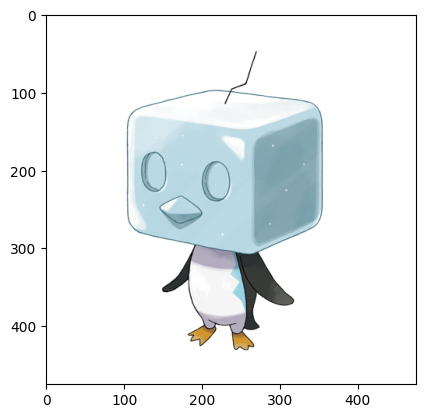

11: 2.7720513343811035


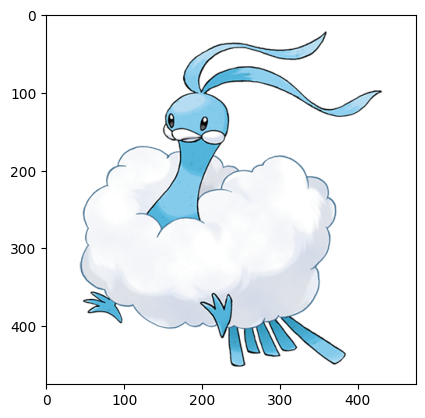

828: 2.7148971557617188


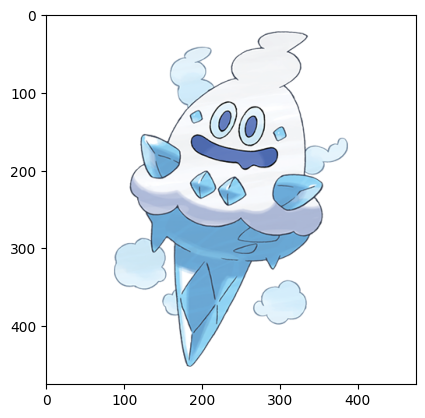

562: 2.7046213150024414


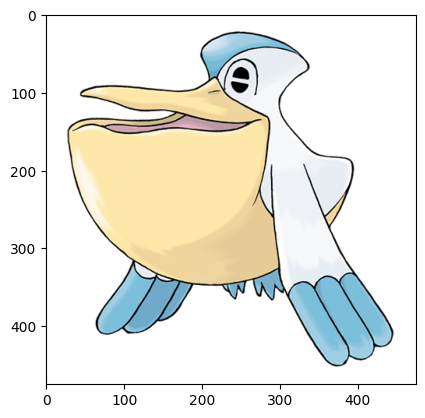

26: 2.6284806728363037


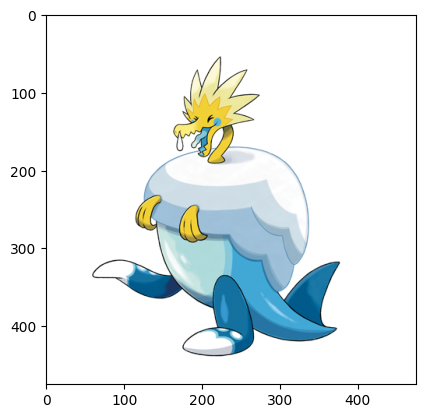

35: 2.625140905380249


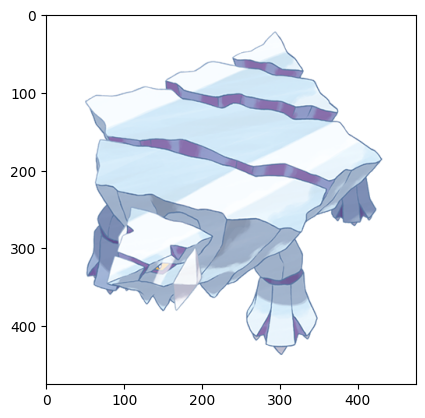

830: 2.623903751373291


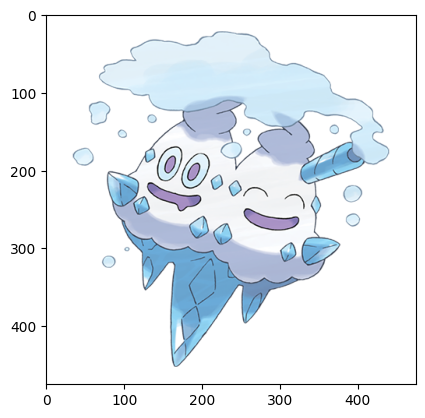

769: 2.6183595657348633


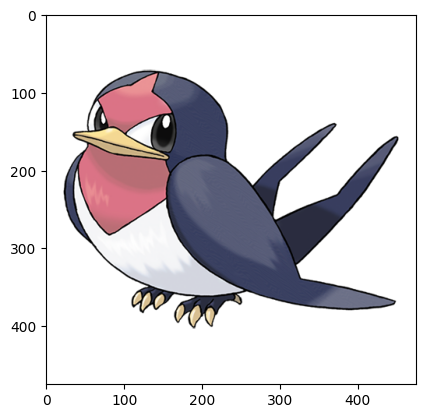

141: 2.6181704998016357


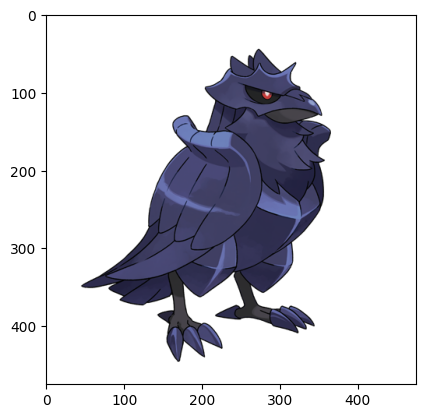

142: 2.6126153469085693


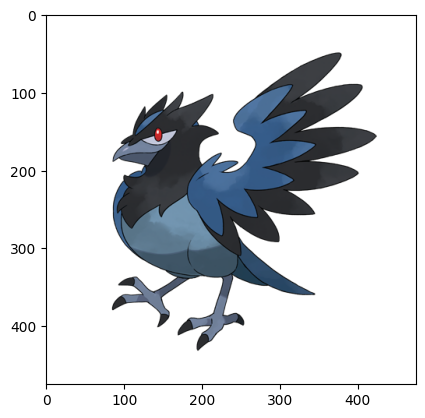

In [20]:
import matplotlib.pyplot as plt

# display the results
for i in idx:
    print(f"{i}: {scores[0][i]}")
    plt.imshow(images[i], cmap='gray')
    plt.show()

In [21]:
df = dataset['train'].to_pandas()
df = df.drop(columns=['image'])
df

,name_en,name_zh,text_en,text_zh,image_filepath
0,abomasnow,暴雪王,"Grass attributes,Blizzard King standing on two...",草属性，双脚站立的暴雪王，全身白色的绒毛，淡紫色的眼睛，几缕长条装的毛皮盖着它的嘴巴,./saved_images/abomasnow_2058735963577945329.png
1,abra,凯西,"Super power attributes, the whole body is yell...",超能力属性，通体黄色，头部外形类似狐狸，尖尖鼻子，手和脚上都有三个指头，长尾巴末端带着一个褐色圆环,./saved_images/abra_5265223410023725368.png
2,absol,阿勃梭鲁,"Evil attribute, with white hair, blue-gray par...",恶属性，有白色毛发，没毛发的部分是蓝灰色，头右边类似弓的角，红色眼睛,./saved_images/absol_-8493509098281981613.png
3,accelgor,敏捷虫,"Insect attributes,upright agile insects, the w...",虫属性，直立型的敏捷虫，全身被粘膜包裹着，脖子下是灰色，头部有一个四角星形状，背后有眼神出去的带子,./saved_images/accelgor_-4254867256317794903.png
4,aegislash-shield,坚盾剑怪,"Steel attribute, huge sword body, hilt, sword ...",钢属性，巨大的剑身，剑柄，剑镡，和金黄色剑脊，深紫色眼睛和手掌，黑色手臂，锯齿状剑锋,./saved_images/aegislash-shield_-9192879603048...
...,...,...,...,...,...
893,zoroark,索罗亚克,"Evil attribute, looks like a gray fox, with a ...",恶属性，外形似灰色狐狸，头上深红色的鬃毛覆盖了后背，爪子、耳朵为红色，耳朵顶端为红色,./saved_images/zoroark_8540914901580778615.png
894,zorua,索罗亚,"Pokémon of the evil attribute, similar in appe...",恶属性，外形类似狐狸崽的宝可梦，身体呈灰黑色，瞳孔呈淡蓝色，脖子上的毛为黑色,./saved_images/zorua_-6649027328925904559.png
895,zubat,超音蝠,It is poisonous and looks like a young bat. It...,毒属性，外形似幼年蝙蝠，通体深蓝色，耳蜗和翼膜是紫色的，没有双眼，四颗白色的牙，尾巴，呈V字形,./saved_images/zubat_6458686427071631846.png
896,zweilous,双首暴龙,"Evil attribute, two heads, blue body, black fu...",恶属性，两个脑袋，身体为蓝色，前身有黑色的毛皮覆盖，背上有一对翅，头发覆盖了双眼,./saved_images/zweilous_-7595618527035249739.png


In [22]:
image_arr.shape

(512, 898)

In [24]:
df['img_emb'] = image_arr.T.tolist()
df

,name_en,name_zh,text_en,text_zh,image_filepath,img_emb
0,abomasnow,暴雪王,"Grass attributes,Blizzard King standing on two...",草属性，双脚站立的暴雪王，全身白色的绒毛，淡紫色的眼睛，几缕长条装的毛皮盖着它的嘴巴,./saved_images/abomasnow_2058735963577945329.png,"[0.037287820130586624, 0.007752994541078806, -..."
1,abra,凯西,"Super power attributes, the whole body is yell...",超能力属性，通体黄色，头部外形类似狐狸，尖尖鼻子，手和脚上都有三个指头，长尾巴末端带着一个褐色圆环,./saved_images/abra_5265223410023725368.png,"[0.023416228592395782, 0.04259476065635681, -0..."
2,absol,阿勃梭鲁,"Evil attribute, with white hair, blue-gray par...",恶属性，有白色毛发，没毛发的部分是蓝灰色，头右边类似弓的角，红色眼睛,./saved_images/absol_-8493509098281981613.png,"[0.045132115483284, 0.015526778064668179, -0.0..."
3,accelgor,敏捷虫,"Insect attributes,upright agile insects, the w...",虫属性，直立型的敏捷虫，全身被粘膜包裹着，脖子下是灰色，头部有一个四角星形状，背后有眼神出去的带子,./saved_images/accelgor_-4254867256317794903.png,"[0.005621279124170542, 0.006194981746375561, -..."
4,aegislash-shield,坚盾剑怪,"Steel attribute, huge sword body, hilt, sword ...",钢属性，巨大的剑身，剑柄，剑镡，和金黄色剑脊，深紫色眼睛和手掌，黑色手臂，锯齿状剑锋,./saved_images/aegislash-shield_-9192879603048...,"[0.02956642583012581, 0.036065127700567245, -0..."
...,...,...,...,...,...,...
893,zoroark,索罗亚克,"Evil attribute, looks like a gray fox, with a ...",恶属性，外形似灰色狐狸，头上深红色的鬃毛覆盖了后背，爪子、耳朵为红色，耳朵顶端为红色,./saved_images/zoroark_8540914901580778615.png,"[0.0383567214012146, -0.02393300086259842, -0...."
894,zorua,索罗亚,"Pokémon of the evil attribute, similar in appe...",恶属性，外形类似狐狸崽的宝可梦，身体呈灰黑色，瞳孔呈淡蓝色，脖子上的毛为黑色,./saved_images/zorua_-6649027328925904559.png,"[0.02846853993833065, -0.024069858714938164, -..."
895,zubat,超音蝠,It is poisonous and looks like a young bat. It...,毒属性，外形似幼年蝙蝠，通体深蓝色，耳蜗和翼膜是紫色的，没有双眼，四颗白色的牙，尾巴，呈V字形,./saved_images/zubat_6458686427071631846.png,"[0.05453715845942497, 0.010203570127487183, -0..."
896,zweilous,双首暴龙,"Evil attribute, two heads, blue body, black fu...",恶属性，两个脑袋，身体为蓝色，前身有黑色的毛皮覆盖，背上有一对翅，头发覆盖了双眼,./saved_images/zweilous_-7595618527035249739.png,"[0.02444298192858696, 0.007616598624736071, -0..."


In [25]:
from sqlalchemy import create_engine

engine = create_engine('postgresql+psycopg://pokemon_user@localhost:5432/pokemon_db')
df.to_sql('pokemons', engine, if_exists='replace', index=False)

-1